In [1]:
pip install ucimlrepo


   ---------------------------------------- 167.3/167.3 kB 1.4 MB/s eta 0:00:00
  Attempting uninstall: certifi
    Found existing installation: certifi 2020.11.8
    Uninstalling certifi-2020.11.8:
      Successfully uninstalled certifi-2020.11.8
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

m = 7, Test Error = 0.060, OOB Error = 0.061
m = 15, Test Error = 0.059, OOB Error = 0.063
m = 3, Test Error = 0.070, OOB Error = 0.072


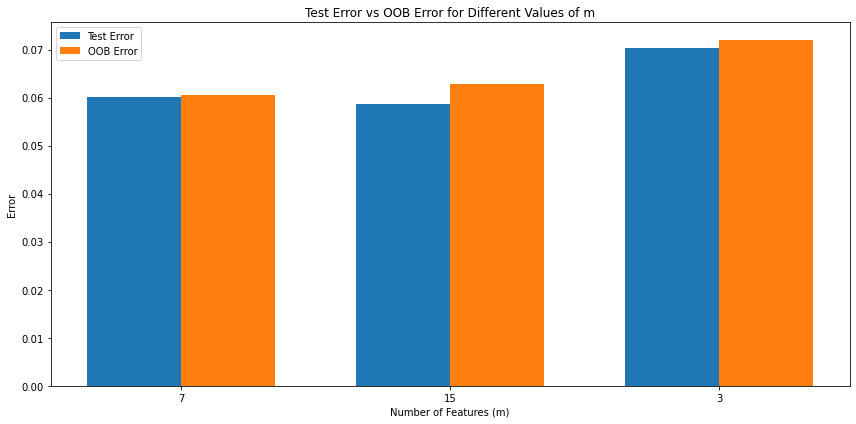

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

# Define the Decision Tree Classifier
class DecisionTree:
    def __init__(self, max_depth=None, m=None):
        self.max_depth = max_depth
        self.m = m
        self.tree = None

    def fit(self, X, y):
        self.features = X.columns
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        if len(np.unique(y)) == 1:
            return y.iloc[0]

        if self.max_depth is not None and depth >= self.max_depth:
            return y.mode()[0]

        best_feature, best_threshold = self._best_split(X, y)

        if best_feature is None:
            return y.mode()[0]

        left_indices = X[best_feature] <= best_threshold
        right_indices = X[best_feature] > best_threshold

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_threshold, left_tree, right_tree)

    def _best_split(self, X, y):
        m = self.m if self.m is not None else int(math.sqrt(len(X.columns)))
        best_gain = 0
        best_feature = None
        best_threshold = None
        
        random_features = np.random.choice(X.columns, size=m, replace=False)

        for feature in random_features:
            thresholds = np.unique(X[feature])
            for threshold in thresholds:
                gain = self._information_gain(X, y, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _information_gain(self, X, y, feature, threshold):
        parent_entropy = self._entropy(y)

        left_indices = X[feature] <= threshold
        right_indices = X[feature] > threshold

        if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
            return 0

        left_entropy = self._entropy(y[left_indices])
        right_entropy = self._entropy(y[right_indices])

        left_weight = len(y[left_indices]) / len(y)
        right_weight = len(y[right_indices]) / len(y)

        child_entropy = left_weight * left_entropy + right_weight * right_entropy

        return parent_entropy - child_entropy

    def _entropy(self, y):
        proportions = np.bincount(y) / len(y)
        return -np.sum(proportions * np.log2(proportions + 1e-10))  # Small constant to avoid log(0)

    def predict(self, X):
        return X.apply(lambda row: self._predict_node(row, self.tree), axis=1)

    def _predict_node(self, row, node):
        if not isinstance(node, tuple):
            return node

        feature, threshold, left_tree, right_tree = node
        if row[feature] <= threshold:
            return self._predict_node(row, left_tree)
        else:
            return self._predict_node(row, right_tree)

# Function to create bootstrap samples
def bootstrap_sample(X_train, y_train, sample_size=2/3):
    n_samples = int(sample_size * len(X_train))
    
    sample_indices = resample(
        np.arange(len(X_train)),
        n_samples=n_samples,
        stratify=y_train,
        replace=True
    )
    
    X_sample = X_train.iloc[sample_indices]
    y_sample = y_train.iloc[sample_indices]
    
    oob_indices = np.setdiff1d(np.arange(len(X_train)), sample_indices)
    
    return X_sample, y_sample, oob_indices

# Random Forest function
def random_forest(X_train, y_train, X_test, y_test, no_of_trees=10, m=None):
    all_predictions = []
    oob_predictions = defaultdict(list)
    
    for i in range(no_of_trees):
        X_bootstrap, y_bootstrap, oob_indices = bootstrap_sample(X_train, y_train)
        
        tree = DecisionTree(max_depth=10, m=m)
        tree.fit(X_bootstrap, y_bootstrap)
        
        if len(oob_indices) > 0:
            X_oob = X_train.iloc[oob_indices]
            oob_predictions_for_tree = tree.predict(X_oob)
            for idx, pred in zip(oob_indices, oob_predictions_for_tree):
                oob_predictions[idx].append(pred)
        
        y_pred = tree.predict(X_test)
        all_predictions.append(y_pred)
    
    all_predictions = np.array(all_predictions)
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=all_predictions)
    accuracy = accuracy_score(y_test, final_predictions)
    
    oob_errors = []
    for i in range(len(X_train)):
        if oob_predictions[i]: 
            final_pred = max(set(oob_predictions[i]), key=oob_predictions[i].count)
            oob_errors.append(final_pred != y_train.iloc[i])

    oob_error = np.mean(oob_errors) if oob_errors else None
    
    return 1 - accuracy, oob_error

# Load the dataset
url = 'https://sites.stat.washington.edu/courses/stat527/s14/homework/hw5/spam.data'
df = pd.read_csv(url, sep=' ', header=None)
features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, stratify=labels, random_state=42)

# Generate m values based on feature count
base_m = math.sqrt(features.shape[1])
m_values = [int(base_m), int(2 * base_m), int(base_m / 2)]


test_errors = []
oob_errors = []

for m in m_values:
    test_error, oob_error = random_forest(X_train, y_train, X_test, y_test, no_of_trees=80, m=m)
    test_errors.append(test_error)
    oob_errors.append(oob_error)
    print(f"m = {m}, Test Error = {test_error:.3f}, OOB Error = {oob_error:.3f}")

# Plotting the errors
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(m_values))

plt.bar(index, test_errors, bar_width, label='Test Error')
plt.bar(index + bar_width, oob_errors, bar_width, label='OOB Error')

plt.xlabel('Number of Features (m)')
plt.ylabel('Error')
plt.title('Test Error vs OOB Error for Different Values of m')
plt.xticks(index + bar_width / 2, m_values)
plt.legend()

plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Load the dataset
url = 'https://sites.stat.washington.edu/courses/stat527/s14/homework/hw5/spam.data'
df = pd.read_csv(url, sep=' ', header=None)

# Split features and labels
features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = rf_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Test Accuracy: 0.9555
Test Precision: 0.9755
Test Recall: 0.9179

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       531
           1       0.98      0.92      0.95       390

    accuracy                           0.96       921
   macro avg       0.96      0.95      0.95       921
weighted avg       0.96      0.96      0.96       921

